# Adversarial domain adaptation

Have you ever deployed a model on data it has never seen? Yes, of course you have.

A new geography to explore, different demographics, a new client, upgraded hardware, all those lead to deployment data that is different than training.
However, getting new labeled data is always expensive. Do we have ways to adapt a model using only unlabeled data?

In this article, we explore why ADDA (Adversarial Discriminative Domain Adaptation, Tzeng et al., 2017) {cite}`adda_2017` is a must-know tool to adapt a model to new unlabeled data.

We will cover:
- Training of a simple MNIST classifier
- Inspection of data shift between MNIST and the USPS dataset
- Adaptation the classifier to the USPS dataset and reduce error from 21% to 9% without using any USPS labels.

First, a few imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Simple MNIST Classifier

In this section, we quickly go over a simple training procedure to get a baseline MNIST classifier.
The classifier will be split into an encoder which projects image to a 256-dimensional embedding, and a head (included in Net) which will classify this embedding into the 10 classes of the MNIST dataset.


In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding="same"),  # (B, 32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 48, 5, padding="valid"),  # (B, 48, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (B, 48, 12, 12)
            nn.Flatten(),  # (B, 48, 12, 12)
            nn.Linear(6912, 256),
        )

    def forward(self, x):
        return self.seq(x)


class Net(nn.Module):
    def __init__(self, encoder=None):
        super().__init__()
        self.encoder = Encoder() if encoder is None else encoder
        self.seq = nn.Sequential(
            nn.ReLU(), nn.Linear(256, 84), nn.ReLU(), nn.Linear(84, 10)
        )

    def forward(self, x, y=None, reduction="mean"):
        x = self.encoder(x)
        x = self.seq(x)

        if y is None:
            return x
        else:
            loss = F.cross_entropy(x, y, reduction=reduction)
            return x, loss

To prepare for later, we will also train a decoder, that maps the embedding back to image space. This is not mandatory, and is only useful for validation and illustration purposes.


In [3]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(256, 48 * 12 * 12),
            nn.ReLU(),
            Reshape(-1, 48, 12, 12),
            nn.Upsample(scale_factor=2, mode="bilinear"),
            nn.Conv2d(48, 32, 5, padding="same"),  # (B, 32, 24, 24)
            nn.ReLU(),
            nn.Upsample(scale_factor=28 / 24, mode="bilinear"),  # (B, 32, 28, 28)
            nn.Conv2d(32, 1, 5, padding="same"),  # (B, 1, 28, 28)
            nn.Tanh(),
        )

    def forward(self, x):
        return self.seq(x)


class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, y=None, reduction="mean"):
        encoded = self.encoder(x)
        output = self.decoder(encoded)

        if y is None:
            return output
        else:
            loss = F.mse_loss(output, x, reduction=reduction)
            return output, loss

Here are the main training procedures that are fairly standard for pytorch. We define an entropy metric which will be useful later. Note that entropy here means the entropy of the predictive distribution, and measures how flat or how peaked the predictive distribution is. It does not use the labels.



In [4]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        _, loss = model(data, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.shape[0]

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss / len(train_loader.dataset):.6f}")


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, loss = model(data, target, reduction="sum")
            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    print(
        f"Test Loss: {test_loss:.6f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)"
    )
    return test_loss, accuracy


def compute_entropy(model, device, test_loader):
    model.eval()
    entropy_total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            ls_output = F.log_softmax(output, dim=-1)
            s_output = F.softmax(output, dim=-1)
            entropy_total += (s_output * ls_output).sum().item()

    entropy_total /= len(test_loader.dataset)
    return -entropy_total

In [5]:
torch.manual_seed(2024)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
# Already normalized between 0 and 1
dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("../data", train=False, transform=transform)

train_kwargs = {"batch_size": 64}
test_kwargs = {"batch_size": 1000}

cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True, "drop_last": True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)


train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

source_encoder = Encoder()
model = Net(encoder=source_encoder).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)

Device: cuda


In [6]:
for epoch in range(1, 9 + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval=1000)
    test(model, device, test_loader)

Epoch: 1
Train Loss: 0.244382
Test Loss: 0.063797, Accuracy: 9814/10000 (98%)
Epoch: 2
Train Loss: 0.058103
Test Loss: 0.037827, Accuracy: 9875/10000 (99%)
Epoch: 3
Train Loss: 0.037859
Test Loss: 0.032907, Accuracy: 9890/10000 (99%)
Epoch: 4
Train Loss: 0.028662
Test Loss: 0.028936, Accuracy: 9907/10000 (99%)
Epoch: 5
Train Loss: 0.021397
Test Loss: 0.035105, Accuracy: 9889/10000 (99%)
Epoch: 6
Train Loss: 0.018342
Test Loss: 0.029899, Accuracy: 9911/10000 (99%)
Epoch: 7
Train Loss: 0.012864
Test Loss: 0.027778, Accuracy: 9917/10000 (99%)
Epoch: 8
Train Loss: 0.011405
Test Loss: 0.030385, Accuracy: 9916/10000 (99%)
Epoch: 9
Train Loss: 0.008913
Test Loss: 0.032024, Accuracy: 9915/10000 (99%)


To help visualize the adaptation process, we will train a decoder based to map the embedding back to image space.

Note that the embedding is fixed here, and has been trained to maximize predictive performance. We would therefore expect the decoder to recreate stereotypical or reference digits that don't necessarily match the input exactly. From an informational perspective, there is no reason to think that the embedding contains much more than class information, since that's what it's been optimized to extract.


In [7]:
# To help visualization, let's train a decoder
decoder = Decoder().to(device)
optimizer = optim.AdamW(decoder.parameters(), lr=3e-4)

autoencoder = AutoEncoder(source_encoder, decoder)

In [8]:
def test_autoencoder(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, loss = model(data, target, reduction="sum")
            test_loss += loss.item() / (28 * 28)

    test_loss /= len(test_loader.dataset)
    print(f"Test loss: {test_loss:.4f}")

for epoch in range(1, 40 + 1):
    train(autoencoder, device, train_loader, optimizer, epoch, log_interval=1000)
    test_autoencoder(autoencoder, device, test_loader)

Epoch: 1
Train Loss: 0.021263
Test loss: 0.0107
Epoch: 2
Train Loss: 0.009271
Test loss: 0.0080
Epoch: 3
Train Loss: 0.007462
Test loss: 0.0068
Epoch: 4
Train Loss: 0.006555
Test loss: 0.0061
Epoch: 5
Train Loss: 0.005961
Test loss: 0.0057
Epoch: 6
Train Loss: 0.005543
Test loss: 0.0054
Epoch: 7
Train Loss: 0.005221
Test loss: 0.0051
Epoch: 8
Train Loss: 0.004983
Test loss: 0.0049
Epoch: 9
Train Loss: 0.004760
Test loss: 0.0047
Epoch: 10
Train Loss: 0.004587
Test loss: 0.0047
Epoch: 11
Train Loss: 0.004439
Test loss: 0.0046
Epoch: 12
Train Loss: 0.004330
Test loss: 0.0044
Epoch: 13
Train Loss: 0.004227
Test loss: 0.0043
Epoch: 14
Train Loss: 0.004133
Test loss: 0.0042
Epoch: 15
Train Loss: 0.004040
Test loss: 0.0041
Epoch: 16
Train Loss: 0.003971
Test loss: 0.0041
Epoch: 17
Train Loss: 0.003904
Test loss: 0.0041
Epoch: 18
Train Loss: 0.003830
Test loss: 0.0041
Epoch: 19
Train Loss: 0.003783
Test loss: 0.0040
Epoch: 20
Train Loss: 0.003733
Test loss: 0.0039
Epoch: 21
Train Loss: 0.00368


With the decoder now trained, we can visualize predictions and reconstructions in the following plot.

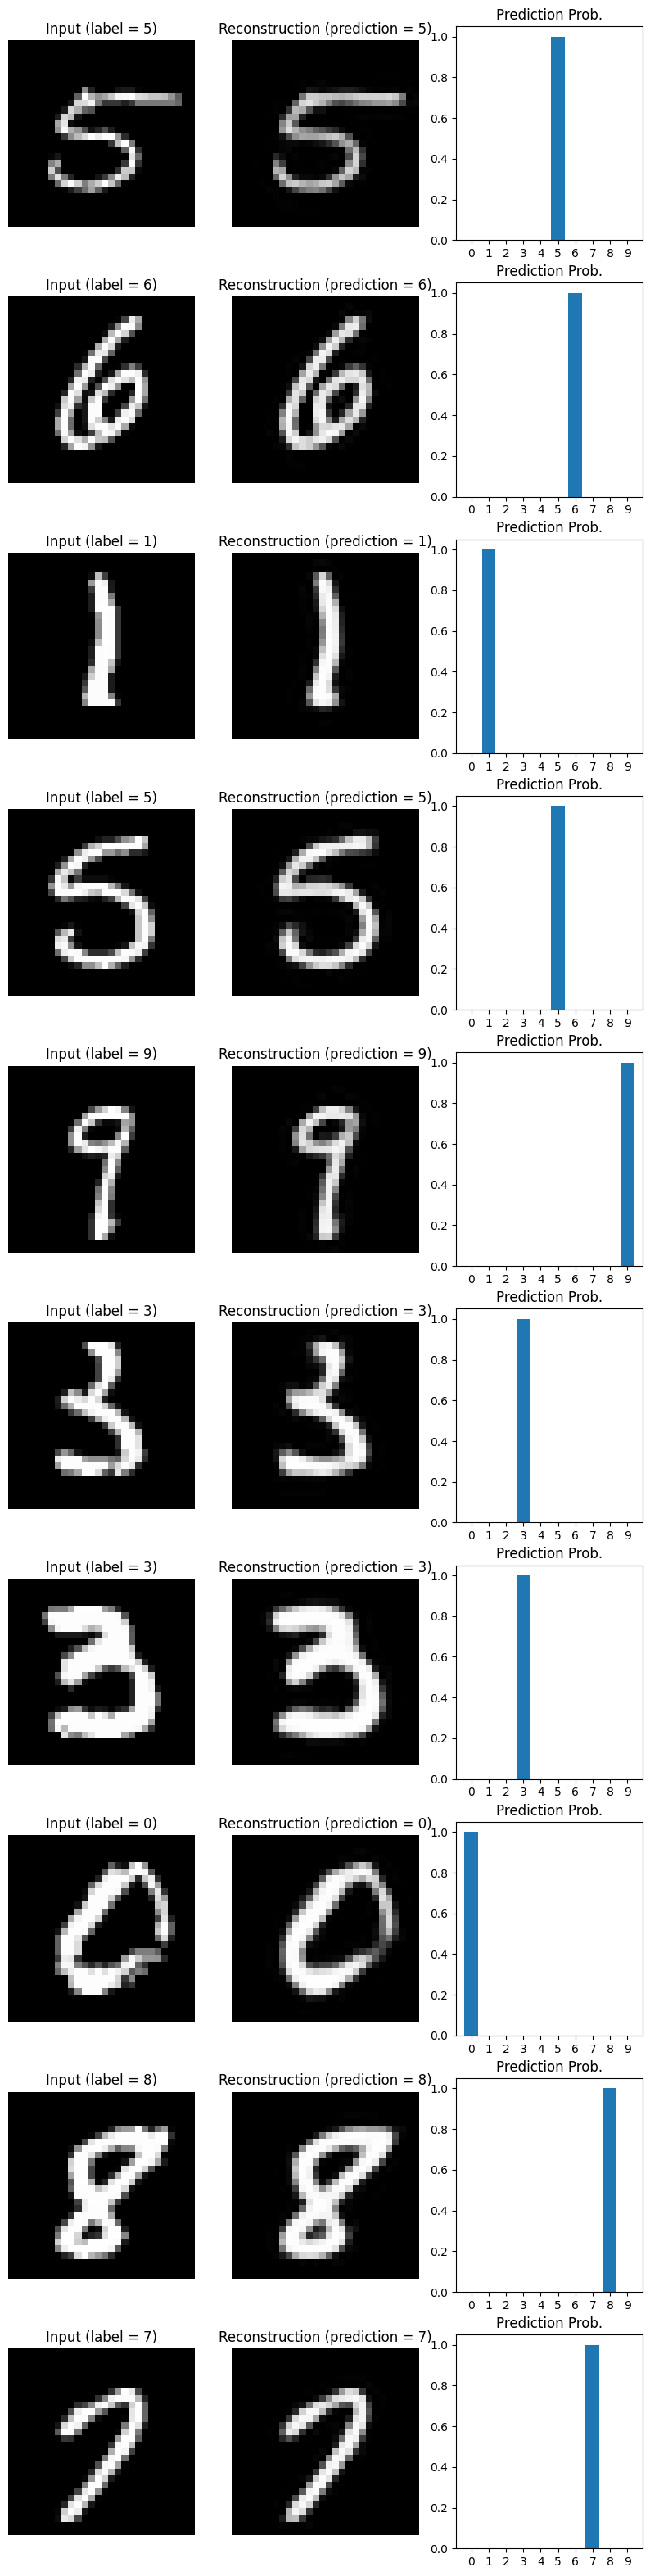

In [9]:
# Viz reconstructions
# note that the embedding is specialized for classification, we would not expect the reconstructions to exactly match the input, but rather a canonical version of the class the input represents.


def to_rgb(x):
    return x.unsqueeze(2).repeat(1, 1, 3).clip(0, 1)


def viz_dataset(autoencoder, loader, model):
    for x, y in loader:
        x_hat = autoencoder(x.to(device))
        y_hat = model(x.to(device))

        n = 10
        fig, axs = plt.subplots(n, 3)  # , sharex=True, sharey=True

        fig.set_figheight(n * 4)
        fig.set_figwidth(10)

        for i in range(10):
            axs[i][0].imshow(to_rgb(x[i, 0]))
            axs[i][0].set_title(f"Input (label = {y[i].item()})")
            axs[i][0].set_axis_off()
            axs[i][1].imshow(to_rgb(x_hat[i, 0].cpu().detach()).numpy())
            axs[i][1].set_title(f"Reconstruction (prediction = {y_hat[i].argmax()})")
            axs[i][1].set_axis_off()

            axs[i][2].bar(range(10), F.softmax(y_hat[i].cpu().detach(), dim=0).numpy())
            axs[i][2].set_title(f"Prediction Prob.")
            axs[i][2].set_xticks(range(10))
        plt.show()
        break

viz_dataset(autoencoder, train_loader, model)

Model outputs for different sample images.

Left column: input data and label

Middle:  Reconstruction from the decoded embedding. 

Right: predictive distribution.

A few findings:
1. The reconstructions are near perfect. This is surprising because this means the embedding still carries spatial information that is not necessarily relevant for classification.
2. The model is very confident in its predictions: the predictive distribution has all its mass on its mode.



## First deployment on USPS data

Let's start by comparing the USPS data with MNIST simply by looking at examples.


In [10]:
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

source_train = train_loader
source_test = test_loader

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(28),
    ]
)

usps_train = datasets.USPS("../data", train=True, download=True, transform=transform)
usps_test = datasets.USPS("../data", train=False, download=True, transform=transform)

target_train = torch.utils.data.DataLoader(usps_train, **train_kwargs)
target_test = torch.utils.data.DataLoader(usps_test, **test_kwargs)


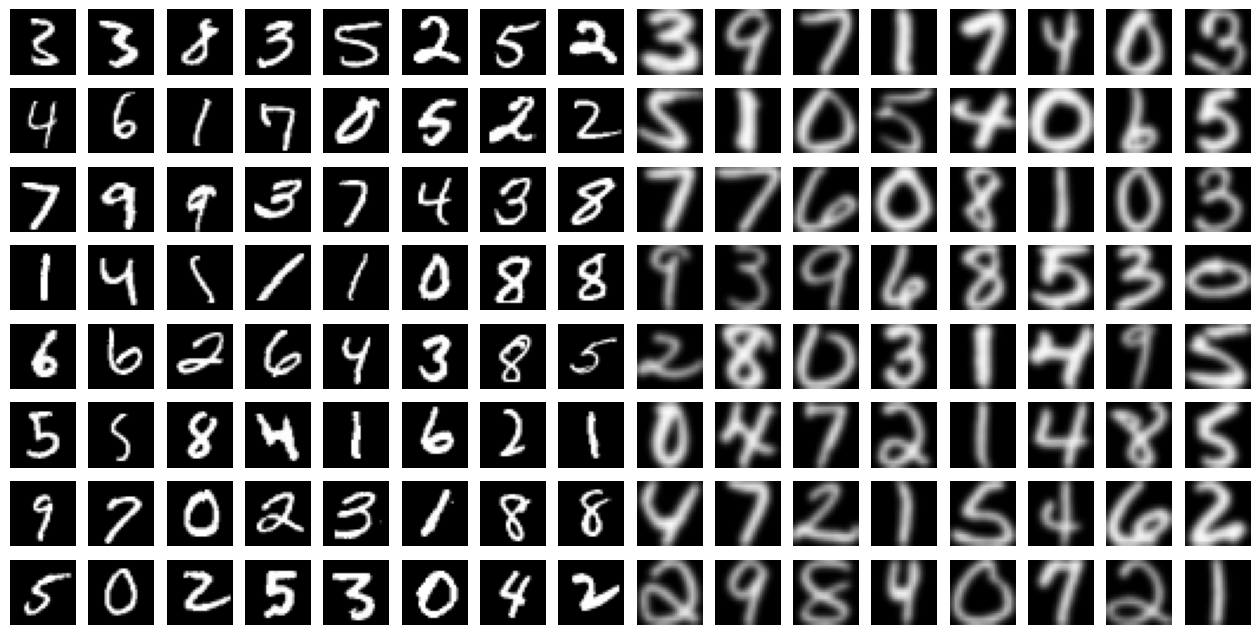

In [11]:
# let's plot a few examples of each:

n = 8
fig, axs = plt.subplots(n, 2 * n, sharex=True, sharey=True) 
fig.set_figheight(n)
fig.set_figwidth(2 * n)

for x, _ in train_loader:
    for k in range(n**2):
        i = k % n
        j = k // n
        axs[i][j].imshow(to_rgb(x[k, 0]))
        axs[i][j].set_axis_off()
    break

for x, _ in target_train:
    for k in range(n**2):
        i = k % n
        j = n + k // n
        axs[i][j].imshow(to_rgb(x[k, 0]))
        axs[i][j].set_axis_off()
    break


On the first half, MNIST digits, on the second half, USPS digits. They are fairly easy to tell apart: USPS digits are blurrier and take up more of the available space, while MNIST is sharper (i.e. pixel intensities are closer to 0 and 1), and leave a bit of room around each digit.
While we could fix those things by manually finding the right image transformation to align them, the goal of this article is to cover cases where the shift is subtle and potentially impossible to visualize.

Let's test how our base classifier is faring on USPS.

Test Loss: 0.889081, Accuracy: 5962/7291 (82%)


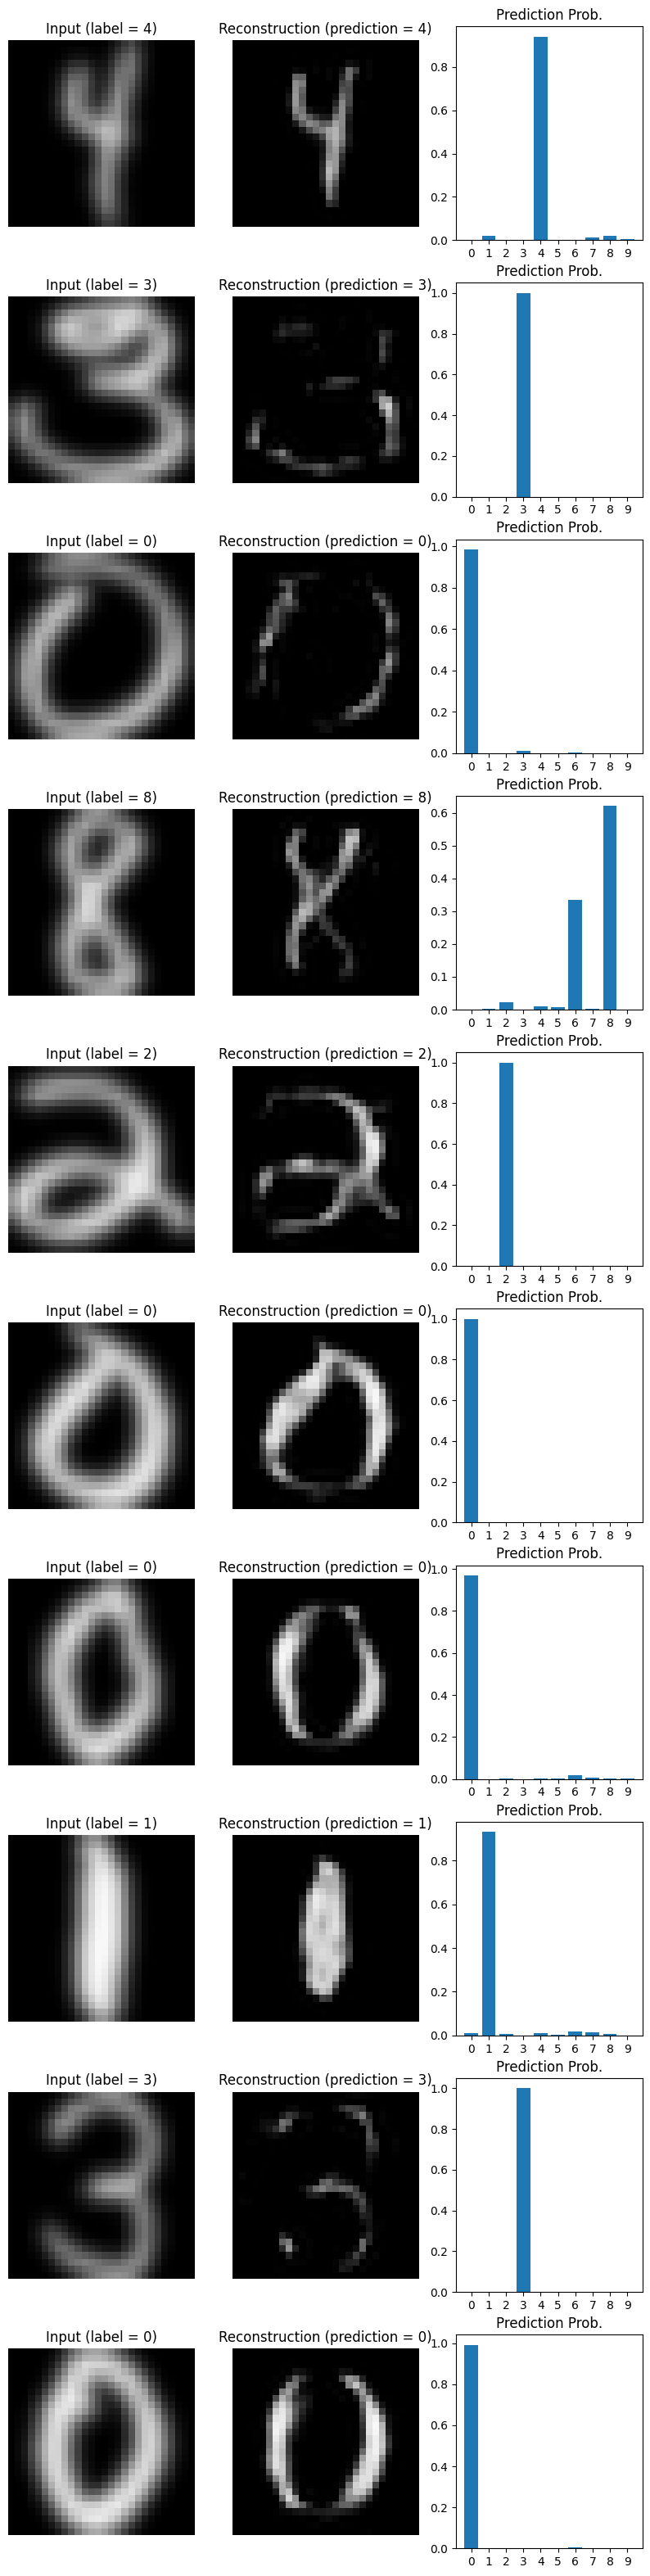

In [ ]:
test(model, device, target_train)
viz_dataset(autoencoder, target_train, model)

Accuracy is around 80% (down from 99% for MNIST). Reconstructions are poor with thin lines.
Predictions are not confident, which I would say is a positive, the model is somewhat honest to the fact that it does not recognize this data really well.

### Visualize the embedding using TSNE


Another tool to visualize embeddings directly (rather than through their reconstruction) is via dimensionality reduction like TSNE.

In [13]:
# Use TSNE to visualize

def predict(model, loader, n=10_000):
    x_batches = []
    y_batches = []
    n_current = 0
    for x, y in loader:
        x_batch = model(x.to(device)).cpu().detach().numpy()
        y_batch = y.numpy()

        k = min(x.shape[0], n - n_current)

        x_batches.append(x_batch[:k])
        y_batches.append(y_batch[:k])

        n_current += k

        if n_current == n:
            break

    x = np.concatenate(x_batches)
    y = np.concatenate(y_batches)
    return x, y


n_tsne = 7000

x_source, y_source = predict(model.encoder, train_loader, n=n_tsne)
x_target, y_target = predict(model.encoder, target_train, n=n_tsne)

x = np.concatenate([x_source, x_target])
tsne = TSNE()
x_2d = tsne.fit_transform(x)
x_2d_source = x_2d[:n_tsne]
x_2d_target = x_2d[n_tsne:]

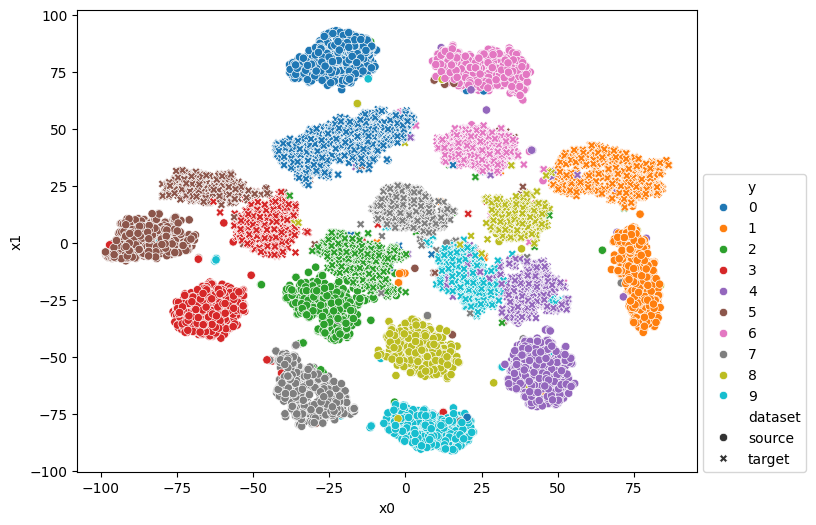

In [14]:
y = np.concatenate([y_source, y_target])

df_plot = pd.DataFrame(
    {
        "x0": x_2d[:, 0],
        "x1": x_2d[:, 1],
        "y": y.astype("str"),
        "dataset": n_tsne * ["source"] + n_tsne * ["target"],
    }
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,  # .sample(frac=0.1),
    x="x0",
    y="x1",
    hue="y",
    style="dataset",
    hue_order=[str(i) for i in range(10)],
)
plt.legend(loc=(1.01, 0))
plt.show()


Using TSNE, we can peek at a two dimensional representation of the 256-dimensional embedded data. Note that TSNE is unaware of both class and dataset of origin during the fit.
However it is able to partition data points into coherent clusters: each cluster has a clear majority class (color), and each cluster comes very predominantly from a single dataset (marker). 

This first observation implies that it should not be too hard to finetune the head to classify USPS (i.e. the target) with little data and get good results. I may add this in the future, but I want to keep the constraints of not using any labeled data for training.

We can also see that eventhough the data cluster nicely, the clustering is cleaner for MNIST than USPS. For example, 4's and 9's are further apart in MNIST than for USPS, where they seem to intersect.

Finally, we also observe that USPS data is on average closer to the origin than MNIST, which tends to be more on the border. This is another sign of the representation being more seperable for MNIST than USPS.

Note that there are certain limits to collapsing a high-dimensional space into 2 dimensions, and certain distances cannot be kept the same, but I do think that the points I have made are not affected by this projection.


Let's look at the confusion matrix and per class accuracy to understand where the model is failing.

In [15]:

pred_source, y_source = predict(model, train_loader, n=n_tsne)
pred_target, y_target = predict(model, target_train, n=n_tsne)

y_pred_source = pred_source.argmax(axis=-1)
y_pred_target = pred_target.argmax(axis=-1)

In [16]:
source_cm = confusion_matrix(y_source, y_pred_source)
source_acc = np.diag(source_cm) / source_cm.sum(axis=-1)

print("Source: MNIST")
print(source_cm)
print(source_acc)

target_cm = confusion_matrix(y_target, y_pred_target)
target_acc = np.diag(target_cm) / target_cm.sum(axis=-1)

print("Target: USPS")

print(target_cm)
print(target_acc)

test(model, device, target_train)
test(model, device, target_test)
None

Source: MNIST
[[698   0   0   0   0   0   1   0   0   0]
 [  0 800   0   0   0   0   0   3   0   0]
 [  0   0 700   0   0   0   0   1   0   0]
 [  0   0   1 684   0   0   0   0   0   0]
 [  0   0   0   0 678   0   0   0   0   1]
 [  0   0   0   1   0 589   1   0   0   0]
 [  0   0   0   0   1   0 688   0   0   0]
 [  0   0   0   0   0   0   0 775   0   0]
 [  0   1   1   1   0   0   1   0 667   0]
 [  0   0   0   1   0   0   0   1   0 705]]
[0.99856938 0.99626401 0.99857347 0.99854015 0.99852725 0.99661591
 0.99854862 1.         0.99403875 0.99717115]
Target: USPS
[[999   2   7 106   0  12  16   0   0   0]
 [  0 926   1   2   0   0  36   0   0   0]
 [  0   3 665  26   1   0   5   2   0   0]
 [  0   0   7 624   0   5   0   1   0   0]
 [  2  15   4   0 520   1  20  57   1   1]
 [  2   0   4  43   0 470   5   5   0   0]
 [ 10   3   1   5   0  11 610   0   0   0]
 [  1  59  37   0   1   0   2 524   0   0]
 [  2  11  13  13   7   3  50   8 412   1]
 [  0  15   1   3 271   1  12 301  14   2]

While MNIST is classified at 99% accuracy across all classes, 9's for USPS are completely missed, and other classes have varying levels of accuracy. The overall rate for USPS remains around 79%.


## Adapting the model to USPS

Let's adapt the model to USPS using ADDA.
The idea is simple: we are going to fine-tune the encoder to produce embeddings that are undistinguishable from the embeddings produced by MNIST.

To do so, we are going to:
- instanciate a new encoder that has the same weight as the MNIST encoder to begin with.
- train that encoder in an adversarial fashion to enforce that the distribution of embeddings between the two dataset becomes the same.
- in order to have an adversarial training, we need to train a discriminator that will try to distinguish between the two datasets.

Note that here, the encoder is the equivalent of the "generator" part of a GAN (generative adversarial network). However, since it is producing a lower-dimensional vector (256), compared to producing a full image (28 * 28 = 784), this is much more efficient than to compute a completely new image.

For simplicity, the discriminator will have a similar architecture to the head of the classifier.

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 2),
        )

    def forward(self, x):
        x = self.seq(x)
        return x

In [33]:
target_encoder = Encoder().to(device)
# The target encoder is initialized with the weights of the source encoder.
target_encoder.load_state_dict(source_encoder.state_dict())

discriminator = Discriminator().to(device)

target_model = Net(target_encoder)
target_model.seq = model.seq
target_model = target_model.to(device)

In [34]:
# we check that the models give similar results at the beginning
test(model, device, target_test)
test(target_model, device, target_test)

Test Loss: 1.001423, Accuracy: 1570/2007 (78%)
Test Loss: 1.000888, Accuracy: 1571/2007 (78%)


(1.000887761973717, 0.7827603388141505)

### Training

The following is a typical training loop for adversarial training. Here are the main steps:
1. grab a batch of source data and target data
2. run them through their respective encoders
3. classify each sample into source (0's) or target (1's) and compute a cross-entropy loss
4. Backpropagate through only the discriminator so it gets better.
5. Now that the discriminator has changed, run the target batch through it again
6. This time we want to improve the generator, so we use a cross-entropy loss with source (0's) labels
7. Backpropagate through the generator only, so that it gets better at generating more source-like embeddings.
 

In [35]:

d_optimizer = optim.AdamW(discriminator.parameters(), lr=3e-5)
te_optimizer = optim.AdamW(target_encoder.parameters(), lr=3e-5)


def train(
    discriminator,
    source_encoder,
    target_encoder,
    device,
    target_train,
    source_train,
    d_optimizer,
    te_optimizer,
    epoch,
    log_interval,
):

    discriminator.train()
    target_encoder.train()
    source_encoder.eval()

    d_loss_total = 0
    d_total = 0

    g_loss_total = 0
    g_total = 0

    for batch_idx, (source_batch, target_batch) in enumerate(
        zip(source_train, target_train)
    ):

        source_x, _ = source_batch
        source_x = source_x.to(device)

        target_x, _ = target_batch
        target_x = target_x.to(device)

        # Update discriminator
        d_optimizer.zero_grad()

        out_source = discriminator(source_encoder(source_x).detach())
        out_target = discriminator(target_encoder(target_x).detach())

        loss_source = F.cross_entropy(
            out_source,
            torch.zeros(train_kwargs["batch_size"], dtype=torch.long, device=device),
        )
        loss_target = F.cross_entropy(
            out_target,
            torch.ones(train_kwargs["batch_size"], dtype=torch.long, device=device),
        )
        d_loss = loss_source + loss_target
        d_loss.backward()
        d_optimizer.step()

        batch_size = source_x.shape[0] + target_x.shape[0]
        d_loss_total += batch_size * d_loss.item()
        d_total += batch_size

        # Update Target encoder
        te_optimizer.zero_grad()
        out_target = discriminator(target_encoder(target_x))
        # here we want the encoder to produce more source-like embeddings
        te_loss = F.cross_entropy(
            out_target,
            torch.zeros(train_kwargs["batch_size"], dtype=torch.long, device=device),
        )

        te_loss.backward()
        te_optimizer.step()

        batch_size = target_x.shape[0]
        g_loss_total += batch_size * te_loss.item()
        g_total += batch_size

    d_loss = d_loss_total / d_total
    g_loss = g_loss_total / g_total
    print(f"Train Epoch: {epoch} \t DLoss: {d_loss:.6f} TELoss: {g_loss:.6f}")

    return d_loss, g_loss

Here is a training procedure that works decently well for this data:
1. warmup with a small learning rate to get the network in a more stable place.
2. increase the learning rate.


In [36]:
# we'll track the following metrics
hist = {
    "d_loss": [],
    "g_loss": [],
    "test_loss": [],
    "test_accuracy": [],
    "test_entropy": [],
}


In [37]:
for epoch in range(1, 30 + 1):
    d_loss, g_loss = train(
        discriminator,
        source_encoder,
        target_encoder,
        device,
        target_train,
        source_train,
        d_optimizer,
        te_optimizer,
        epoch,
        log_interval=1000,
    )
    hist["d_loss"].append(d_loss)
    hist["g_loss"].append(g_loss)
    test_loss, test_accuracy = test(target_model, device, target_test)

    hist["test_loss"].append(test_loss)
    hist["test_accuracy"].append(test_accuracy)
    hist["test_entropy"].append(compute_entropy(target_model, device, target_train))
    print(f"Test entropy: {hist['test_entropy'][-1]: .6f}")


Train Epoch: 1 	 DLoss: 1.100269 TELoss: 0.681231
Test Loss: 0.687393, Accuracy: 1626/2007 (81%)
Test entropy:  0.235374
Train Epoch: 2 	 DLoss: 0.981219 TELoss: 0.782155
Test Loss: 0.805942, Accuracy: 1563/2007 (78%)
Test entropy:  0.406942
Train Epoch: 3 	 DLoss: 0.848668 TELoss: 0.825000
Test Loss: 0.749277, Accuracy: 1573/2007 (78%)
Test entropy:  0.602024
Train Epoch: 4 	 DLoss: 0.800949 TELoss: 0.916059
Test Loss: 0.917364, Accuracy: 1483/2007 (74%)
Test entropy:  0.793002
Train Epoch: 5 	 DLoss: 0.700257 TELoss: 0.976722
Test Loss: 0.572987, Accuracy: 1653/2007 (82%)
Test entropy:  0.578317
Train Epoch: 6 	 DLoss: 0.762881 TELoss: 1.027083
Test Loss: 0.700377, Accuracy: 1605/2007 (80%)
Test entropy:  0.744050
Train Epoch: 7 	 DLoss: 0.695208 TELoss: 0.984430
Test Loss: 0.676700, Accuracy: 1587/2007 (79%)
Test entropy:  0.653053
Train Epoch: 8 	 DLoss: 0.688933 TELoss: 1.094555
Test Loss: 0.448379, Accuracy: 1713/2007 (85%)
Test entropy:  0.399793
Train Epoch: 9 	 DLoss: 0.750267

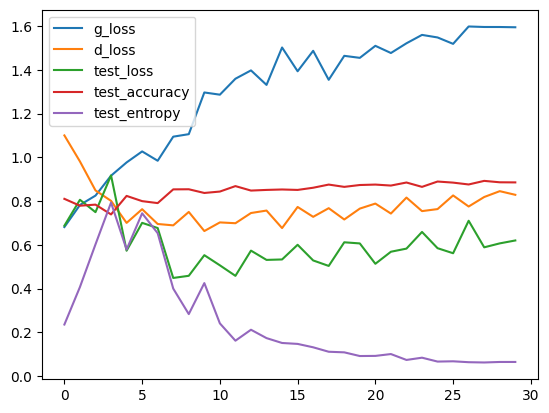

In [38]:
plt.plot(hist["g_loss"], label="g_loss")
plt.plot(hist["d_loss"], label="d_loss")
plt.plot(hist["test_loss"], label="test_loss")
plt.plot(hist["test_accuracy"], label="test_accuracy")
plt.plot(hist["test_entropy"], label="test_entropy")
plt.legend()
plt.show()

In [39]:
# After warmup we can increase learning rate ?

for g in optimizer.param_groups:
    g["lr"] = 1e-3


for epoch in range(1, 300 + 1):
    d_loss, g_loss = train(
        discriminator,
        source_encoder,
        target_encoder,
        device,
        target_train,
        source_train,
        d_optimizer,
        te_optimizer,
        epoch,
        log_interval=1000,
    )
    hist["d_loss"].append(d_loss)
    hist["g_loss"].append(g_loss)
    test_loss, test_accuracy = test(target_model, device, target_test)

    hist["test_loss"].append(test_loss)
    hist["test_accuracy"].append(test_accuracy)

    hist["test_entropy"].append(compute_entropy(target_model, device, target_train))
    print(f"Test entropy: {hist['test_entropy'][-1]: .6f}")

Train Epoch: 1 	 DLoss: 0.843383 TELoss: 1.515358
Test Loss: 0.691970, Accuracy: 1775/2007 (88%)
Test entropy:  0.053726
Train Epoch: 2 	 DLoss: 0.856212 TELoss: 1.617071
Test Loss: 0.578301, Accuracy: 1791/2007 (89%)
Test entropy:  0.057727
Train Epoch: 3 	 DLoss: 0.801790 TELoss: 1.543685
Test Loss: 0.553441, Accuracy: 1780/2007 (89%)
Test entropy:  0.066383
Train Epoch: 4 	 DLoss: 0.870805 TELoss: 1.450558
Test Loss: 0.632021, Accuracy: 1775/2007 (88%)
Test entropy:  0.053035
Train Epoch: 5 	 DLoss: 0.868140 TELoss: 1.563149
Test Loss: 0.629229, Accuracy: 1770/2007 (88%)
Test entropy:  0.053594
Train Epoch: 6 	 DLoss: 0.832501 TELoss: 1.525388
Test Loss: 0.600805, Accuracy: 1778/2007 (89%)
Test entropy:  0.060777
Train Epoch: 7 	 DLoss: 0.819728 TELoss: 1.505711
Test Loss: 0.592271, Accuracy: 1789/2007 (89%)
Test entropy:  0.053912
Train Epoch: 8 	 DLoss: 0.864361 TELoss: 1.464429
Test Loss: 0.658406, Accuracy: 1775/2007 (88%)
Test entropy:  0.058964
Train Epoch: 9 	 DLoss: 0.849032

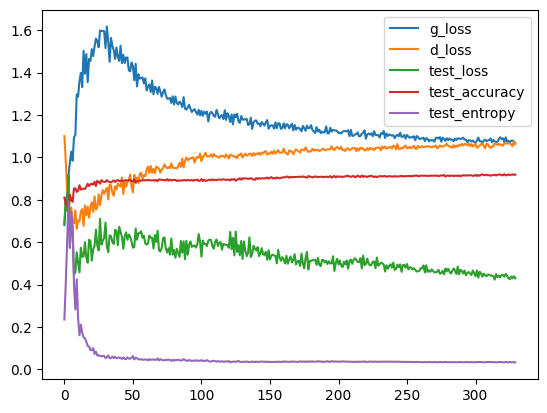

In [40]:
plt.plot(hist["g_loss"], label="g_loss")
plt.plot(hist["d_loss"], label="d_loss")
plt.plot(hist["test_loss"], label="test_loss")
plt.plot(hist["test_accuracy"], label="test_accuracy")
plt.plot(hist["test_entropy"], label="test_entropy")
plt.legend()
plt.show()

Let's unpack what just happened! We just trained a new encoder in an adversarial fashion so that the embedding created on the USPS dataset look like the embedding created from the MNIST dataset.
The generator and discriminator loss tell us how performant is each part of the network. However, like with any GAN set-up you can't expect them to go to 0 like in supervised training as those are essentially fighting against each other. It is good to not see one completely overtake the other though. We are good there.

What about test metrics? I chose to add three:
1. Test loss is the cross-entropy loss of the classifier formed by the new encoder stacked with the previous classifier head. This is the model that we want to deploy on USPS.
2. Accuracy is the accuracy of that same model.
3. BUT, you would not have access to those in any real-case scenario if you don't have labeled data, they are simply meant as a verification metric here to prove the efficacy of the procedure.
4. The test entropy measures the model confidence in its prediction (regardless of what the prediction is). This metric is available in practice since it does not depend on labels.

Those three seem to converge fairly quickly during training. In particular, accuracy quickly reaches 92% (up from 78%). That's a great improvement!

What is a little crazy to me is that this procedure does not use any label, and the only real link to labeled data is that fact that the encoder was initialized from the MNIST encoder. Even after all that training, it has kept that prior knowledge.

The fact that this kind of adaptation works is not trivial and it practice it does not work all the time.

### Analysis

Let's investigate the new model further to understand. First, a quick glance at the previous vs new model on the test data:

In [43]:
test(model, device, target_test)
test(target_model, device, target_test)

Test Loss: 0.993355, Accuracy: 1573/2007 (78%)
Test Loss: 0.429502, Accuracy: 1844/2007 (92%)


(0.4295015206786015, 0.918784255107125)

Second let's visualize how the new model performs using reconstructions and predictive probabilities.

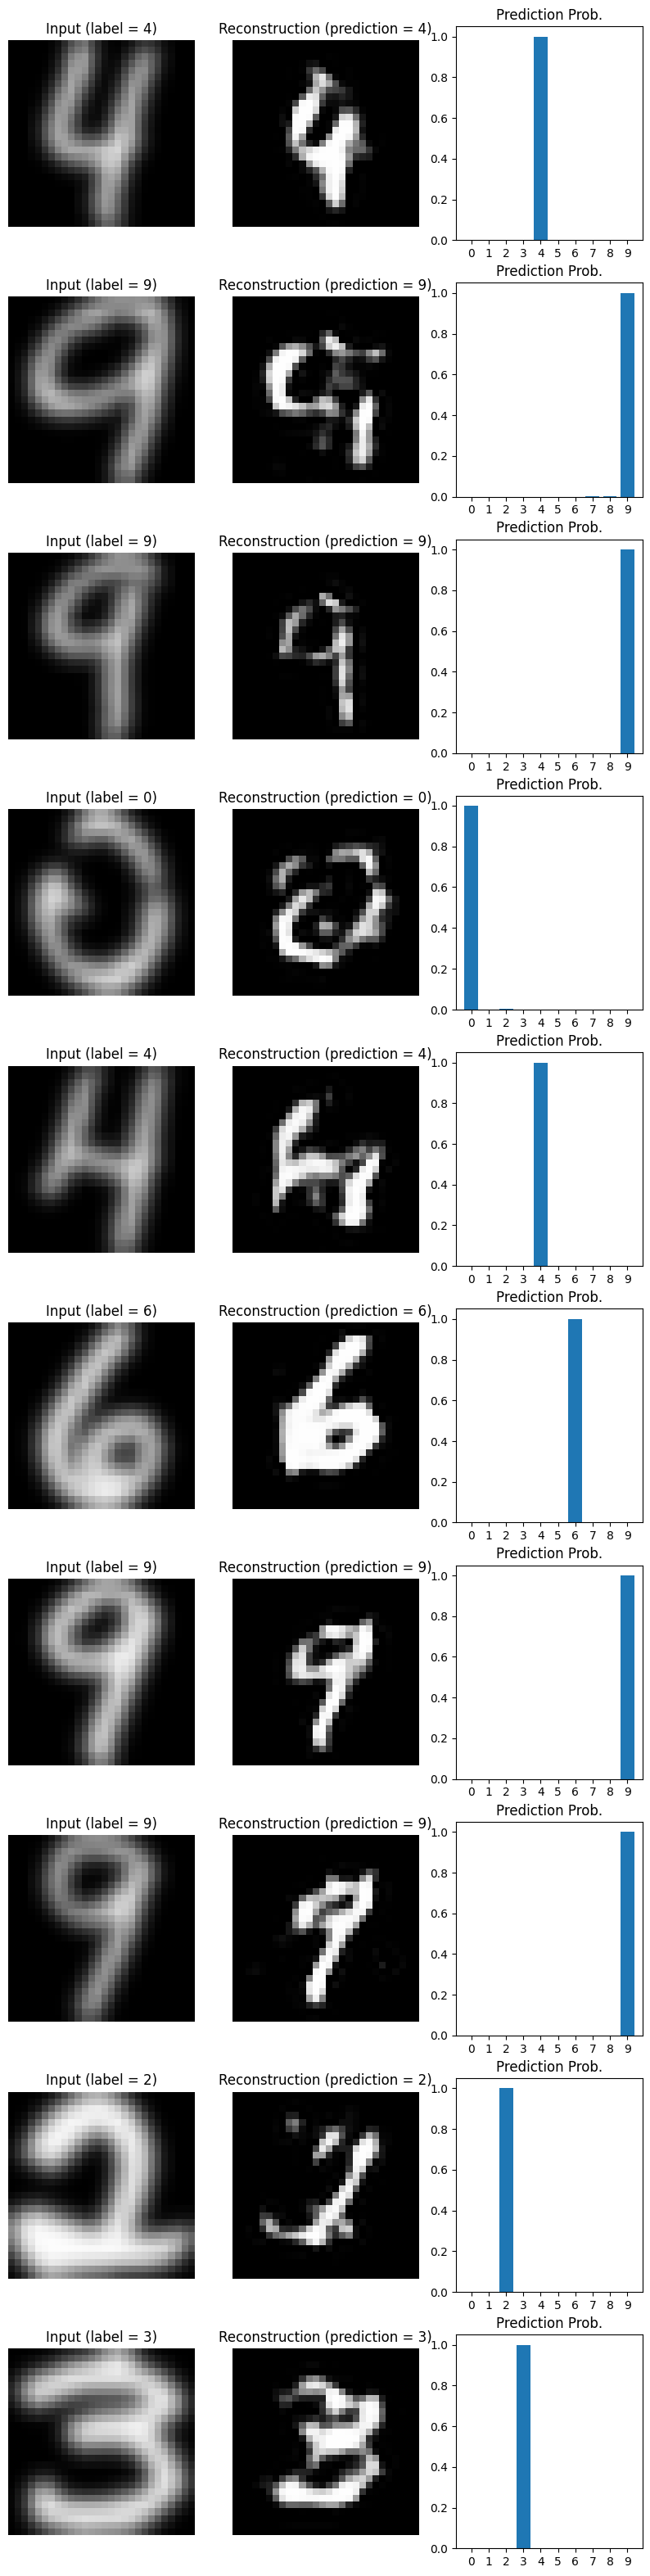

In [44]:
target_autoencoder = AutoEncoder(target_encoder, decoder)
viz_dataset(target_autoencoder, target_train, target_model)

The predictions are mostly good (90% accuracy), and the predictive distributions are very peaked (which is consistent with the entropy we were tracking over time).
The reconstructions are not prestine, the labels is clearly conserved between the two, but a lot of irrealistic artefacts can be spotted.
This would indicate that the embeddings are not completely the same between MNIST and USPS, otherwise the reconstructions would have high quality.

Let's inspect the embeddings directly using TSNE to compare with the previous encoder:

In [45]:
n_tsne = 7000

x_source, y_source = predict(model.encoder, train_loader, n=n_tsne)
x_target, y_target = predict(target_encoder, target_train, n=n_tsne)

x = np.concatenate([x_source, x_target])
tsne = TSNE()
x_2d = tsne.fit_transform(x)
x_2d_source = x_2d[:n_tsne]
x_2d_target = x_2d[n_tsne:]

y = np.concatenate([y_source, y_target])

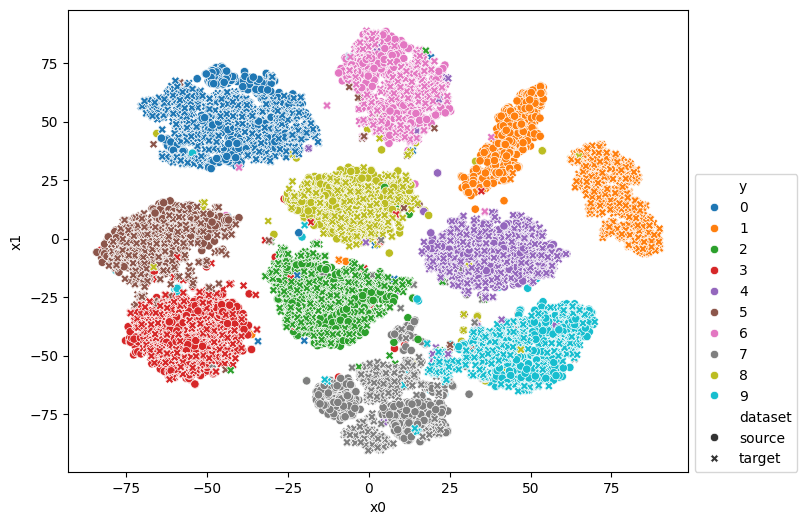

In [46]:
df_plot = pd.DataFrame(
    {
        "x0": x_2d[:, 0],
        "x1": x_2d[:, 1],
        "y": y.astype("str"),
        "dataset": n_tsne * ["source"] + n_tsne * ["target"],
    }
)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_plot,  # .sample(frac=0.1),
    x="x0",
    y="x1",
    hue="y",
    style="dataset",
    hue_order=[str(i) for i in range(10)],
)
plt.legend(loc=(1.01, 0))
plt.show()

This TSNE embedding is very encouraging. First off, we still have clusters with mostly a single dominant label (color here). Secondly, source and target datapoints are now much more mixed within each cluster, which seems to indicate that the adversarial training is working. We still see dataset-specific clusters, such as 1's here, or 7's which seem to be sub-partitioned. There does not seem to be a specific direction or region of the space where USPS is more likely to be.
This is very encouraging. Notice how 4's and 9's which used to be very close with the previous encoder are now much more distinct.

In different runs we can have different results, so I am not sure this is always reproduceable. In certain runs with good test accuracy, I still got different clusters per datasets, but the clusters were at least adjacent.

We haven't paused to much to consider whether it was even possible for the encoder to generate embeddings that look similar to MNIST ones from a capacity standpoint. In particular, the use of RELU non linearity when training MNIST can "kill" parts of the network and render impossible any further fine-tuning. In a practical scenario, I think keeping an eye on the sparsity of activation can be a decent measure of future model fine-tuneability.

To finish, let's look at the confusion matrix:

In [49]:
from sklearn.metrics import confusion_matrix


pred_source, y_source = predict(model, train_loader, n=n_tsne)
pred_target, y_target = predict(target_model, target_train, n=n_tsne)


y_pred_source = pred_source.argmax(axis=-1)
y_pred_target = pred_target.argmax(axis=-1)


source_cm = confusion_matrix(y_source, y_pred_source)
source_acc = np.diag(source_cm) / source_cm.sum(axis=-1)

print("MNIST:")
print(source_cm)
print(source_acc)

target_cm_adda = confusion_matrix(y_target, y_pred_target)
target_acc_adda = np.diag(target_cm_adda) / target_cm_adda.sum(axis=-1)

print("USPS:")
print(target_cm_adda)
print(target_acc_adda)
print("Previous (for comparison):")
print(target_cm)
print(target_acc)


MNIST:
[[662   0   0   0   0   0   1   0   0   0]
 [  0 803   0   1   0   1   0   2   0   0]
 [  0   0 723   0   0   0   0   2   0   0]
 [  0   0   0 731   0   0   0   0   0   0]
 [  0   0   0   0 708   0   0   1   0   0]
 [  0   0   0   0   0 580   1   0   0   0]
 [  0   0   0   0   0   0 673   0   0   0]
 [  0   0   0   0   0   0   0 705   0   0]
 [  0   0   3   1   0   0   1   0 673   0]
 [  0   0   0   1   1   0   0   0   0 726]]
[0.9984917  0.99504337 0.99724138 1.         0.99858956 0.99827883
 1.         1.         0.99262537 0.99725275]
USPS:
[[1120    1    5    2    0    3   10    1   10    0]
 [   0  962    0    1    0    0    0    1    0    0]
 [   0    3  670    7    8    0    3   13    1    0]
 [   0    0    6  613    0    4    0    2    1    1]
 [   0    3    2    0  592    0    5   20    2    7]
 [   2    0    2   53    0  465    9    3    1    2]
 [   0    0    0    0    3    0  622    0    2    0]
 [   0    0    6    2    1    0    0  614    0    1]
 [   1    4    2   

In the new model, we see that the largest error is classifying 9's as 7's (which we can see are adjacent in the TSNE plots).
When comparing with the previous model, accuracy can improve dramatically: for 9's it goes from 0% to 80%. Most of them increase except 3's went from 97.9% to 97.7%.
In the ADDA paper they show a few datasets that go down in accuracy, but success is likely if the datasets are not completely different.


We can look at 9's in particular to investigate: but I am not seeing an obvious thing to fix.


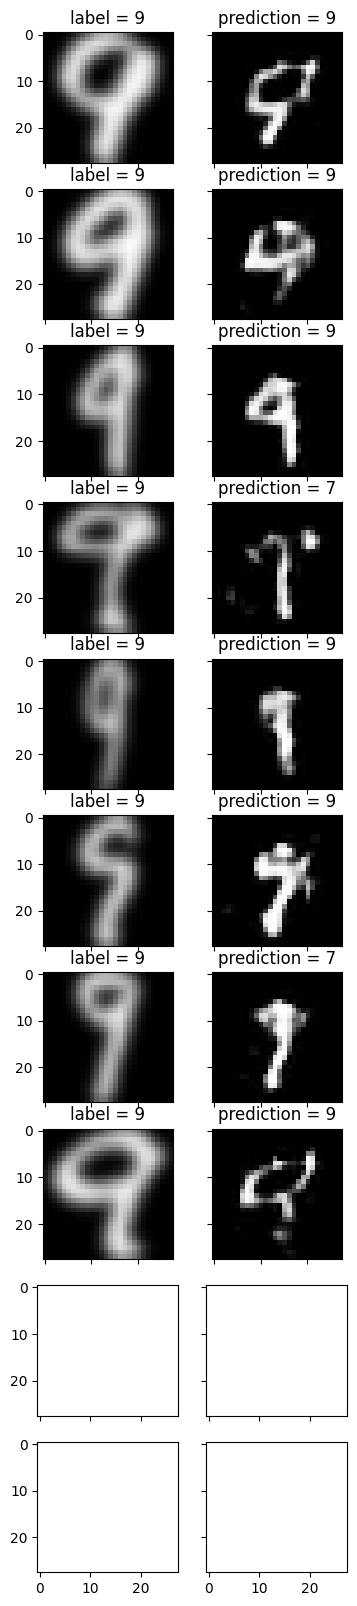

In [50]:
# We have 10% of 9's that are interpreted as 7

def inspect(autoencoder, loader, model):
    for x, y in loader:
        x_hat = autoencoder(x.to(device))
        y_hat = model(x.to(device))

        x = x[y == 9]
        x_hat = x_hat[y == 9]
        y_hat = y_hat[y == 9]
        y = y[y == 9]

        n = 10
        fig, axs = plt.subplots(n, 2, sharex=True, sharey=True)

        fig.set_figheight(n * 2)
        fig.set_figwidth(4)

        for i in range(x_hat.shape[0]):
            axs[i][0].imshow(to_rgb(x[i, 0]))
            axs[i][0].set_title(f"label = {y[i].item()}")
            axs[i][1].imshow(to_rgb(x_hat[i, 0].cpu().detach()).numpy())

            axs[i][1].set_title(f"prediction = {y_hat[i].argmax()}")
        plt.show()
        break


inspect(target_autoencoder, target_train, target_model)

## Conclusion

In this article we have explored how to adapt a model to a new dataset using ADDA, and how to evaluate and understand it. 
By using this technique we've been able to reduce the error rate from 21% to 8% without introducing major architecture changes. We simply fine-tuned network architectures that we got from the original model.

The subject of domain-adaptation is vast, but I hope this adds a new tool to your toolbox and helps you build intuition for your next out-of-distribution deployments.
